In [2]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import os
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
from dtree import DT

path = 'C:/Code/UTEC/ML/Project2/tos/cleaned_data/'

np.random.seed(42)

In [3]:
def encode(path):
    positives = []
    positives_directory = os.listdir(path + "Positive")
    print("Loading positives...")
    for f in positives_directory:
        y, sr = librosa.load(path + "Positive/" + f)
        mfccs = librosa.feature.mfcc(y=y, sr=sr)
        fv = mfccs.mean(axis=1)
        positives.append(fv)
    positives_array = np.array(positives)
    positives_array = np.insert(positives_array, 0, 1, axis=1)
    print("Loading finished!")

    negatives = []
    negatives_directory = os.listdir(path + "Negative")
    print("Loading negatives...")
    for f in negatives_directory:
        y, sr = librosa.load(path + "Negative/" + f)
        mfccs = librosa.feature.mfcc(y=y, sr=sr)
        fv = mfccs.mean(axis=1)
        negatives.append(fv)
    negatives_array = np.array(negatives)
    negatives_array = np.insert(negatives_array, 0, -1, axis=1)
    print("Loading finished!")

    print("Joining and shuffling loaded data...")
    result_array = np.concatenate((positives_array, negatives_array), axis=0)
    np.random.shuffle(result_array)
    y = result_array[:, 0]
    x = result_array[:, 1:]
    print("Done!")
    return x, y

In [4]:
def matriz_confusion(y_pred, y_test, Tipo):
    matrix = confusion_matrix(y_test, y_pred)
    f2 = pd.DataFrame(matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis], index=["Negative", 'Positive'],
                      columns=["Negative", 'Positive'])
    sns.heatmap(f2, annot=True, cbar=None, cmap="Greens")
    plt.title("Confusion Matrix" + Tipo), plt.tight_layout()
    plt.xlabel("Predicted")
    plt.ylabel("Real")
    plt.show()

In [5]:
X_data, Y_data = encode(path)
sm = SMOTE(random_state=42)
X_data, Y_data = sm.fit_resample(X_data, Y_data)
x_train, x_test, y_train, y_test = train_test_split(X_data, Y_data, test_size=0.3)
print(X_data.shape, Y_data.shape)


Loading positives...
Loading finished!
Loading negatives...
Loading finished!
Joining and shuffling loaded data...
Done!
(2414, 20) (2414,)


# DTree

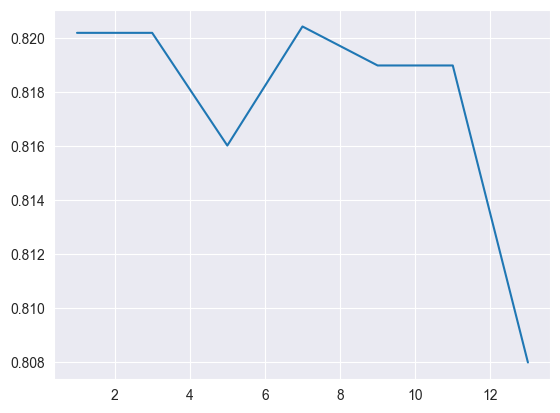

In [7]:
k = [1, 3, 5, 7, 9, 11, 13]
f1_scores_dt = []
for i in k:
    dt = DT(x_train, y_train, min_samples_node=i)
    y_pred = dt.predict(x_test)
    report = classification_report(y_test, y_pred, target_names=["Negative", "Positive"], output_dict=True)
    f1_score = report['weighted avg']['f1-score']
    f1_scores_dt.append(f1_score)

plt.plot(k, f1_scores_dt)




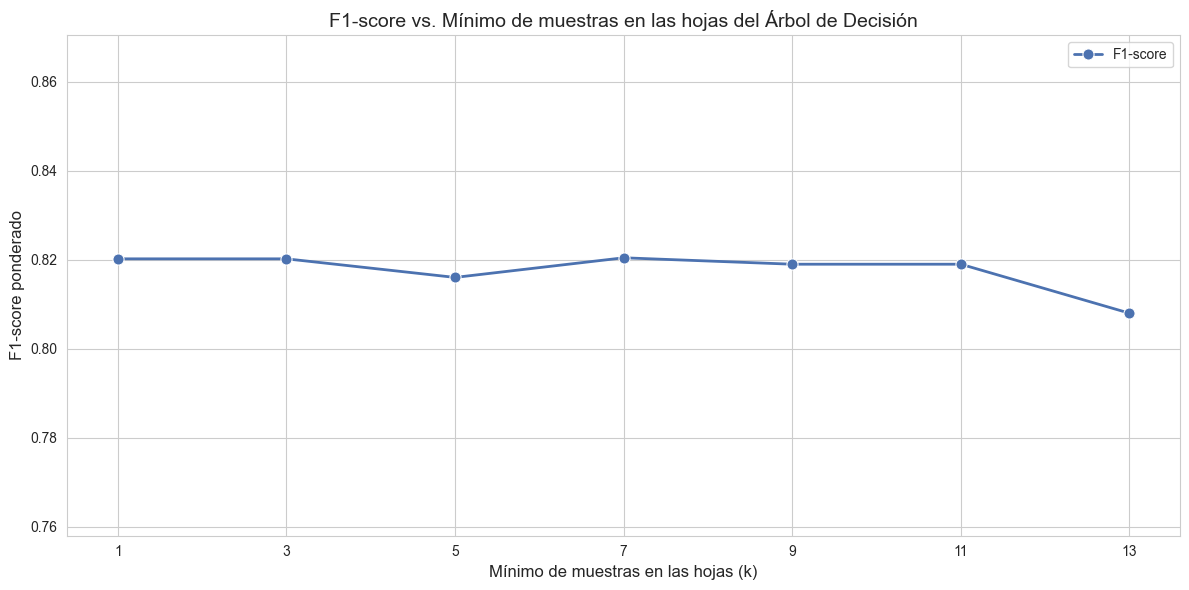

In [9]:
df = pd.DataFrame({'Min samples leaf': k, 'F1-score': f1_scores_dt})

sns.set_style("whitegrid")
sns.set_palette("deep")

plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='Min samples leaf', y='F1-score', marker='o', linewidth=2, markersize=8)

plt.xlabel('Mínimo de muestras en las hojas (k)', fontsize=12)
plt.ylabel('F1-score ponderado', fontsize=12)
plt.title('F1-score vs. Mínimo de muestras en las hojas del Árbol de Decisión', fontsize=14)

plt.legend(['F1-score'], loc='best', fontsize=10)
plt.xticks(k)
plt.ylim(min(f1_scores_dt) - 0.05, max(f1_scores_dt) + 0.05)

# for x, y in zip(k, f1_scores_dt):
#     plt.text(x, y, f'{y:.3f}', ha='center', va='bottom', fontsize=9)

# Mostrar el gráfico
plt.tight_layout()
plt.show()

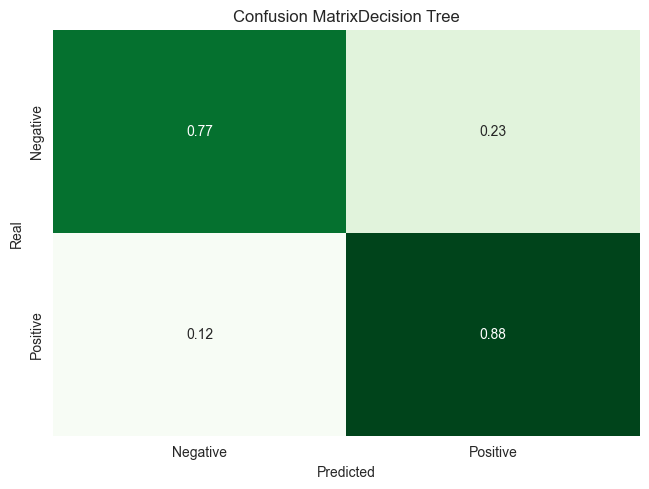

In [10]:
dt_2 = DT(x_train, y_train, min_samples_node=11)
y_pred_2 = dt_2.predict(x_test)
matriz_confusion(y_pred_2, y_test, "Decision Tree")

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report

np.random.seed(42)

n_folds = 10
kfold = KFold(n_splits=n_folds, shuffle=True, random_state=41)

accuracy_train = []
accuracy_test = []
precision_test = []
recall_test = []
f1_test = []


# Iterar por cada fold
i = 0
for train_index, test_index in kfold.split(X_data, Y_data):
    i += 1
    x_traink, x_testk = X_data[train_index], X_data[test_index]
    y_traink, y_testk = Y_data[train_index], Y_data[test_index]

    model = DT(x_traink, y_traink, min_samples_node=11)  
    
    y_train_pred = model.predict(x_traink)
    y_test_pred = model.predict(x_testk)
    
    train_accuracy = accuracy_score(y_traink, y_train_pred)
    test_accuracy = accuracy_score(y_testk, y_test_pred)
    
    accuracy_train.append(train_accuracy)
    accuracy_test.append(test_accuracy)
    
    print(f"Fold {i}:")
    print(f"Train Accuracy: {train_accuracy}")
    print(f"Test Accuracy: {test_accuracy}")
    
    print(classification_report(y_testk, y_test_pred, target_names=["Negative", "Positive"]))

plt.plot(accuracy_train, label="Train Accuracy")
plt.plot(accuracy_test, label="Test Accuracy")
plt.legend()
plt.show()


# SVM

In [12]:
import numpy as np


class SVM:
    def __init__(self, c=1e8, alpha=1e-10, epochs=39000):
        self.c = c
        self.alpha = alpha
        self.epochs = epochs
        self.w = None
        self.b = None
        self.error = []

    def normalize(self, data):
        min = np.min(data, axis=0)
        max = np.max(data, axis=0)
        return (data - min) / (max - min)

    def h(self, x):
        return np.dot(x, self.w.T) + self.b

    def loss(self, y, y_aprox):
        return 1 / 2 * np.linalg.norm(self.w) ** 2 + self.c * np.sum(np.maximum(0, 1 - y * y_aprox))

    def derivatives(self, x, y, y_aprox):
        n = x.shape[0]
        dw = np.zeros(self.w.shape)
        db = 0.0

        for i in range(n):
            if (y[i] * y_aprox[i]) < 1:
                dw += self.c * -y[i] * x[i]
                db += self.c * -y[i]
        dw += self.w

        return dw, db

    def update(self, x, y, y_aprox, dw, db):
        n = x.shape[0]

        for i in range(n):
            if y[i] * y_aprox[i] < 1:
                self.w -= self.alpha * dw
                self.b -= self.alpha * db
            else:
                self.w -= self.alpha * self.w

    def train(self, x, y):
        x = self.normalize(x)
        self.w = np.array([np.random.rand() for _ in range(x.shape[1])])
        self.b = np.random.rand()

        for _ in range(self.epochs):
            y_aprox = self.h(x)
            dw, db = self.derivatives(x, y, y_aprox)
            self.update(x, y, y_aprox, dw, db)
            L = self.loss(y, y_aprox)
            self.error.append(L)
        return self.w, self.b, self.error

    def polynomial(self, x_ind, x, c, n):
        return (np.dot(x_ind, x) + c) ** n

    def predict(self, x):
        x = self.normalize(x)
        y_aprox = []
        for i in range(x.shape[0]):
            y_aprox.append(np.sign(np.dot(x[i], self.w.transpose()) + self.b))
        return np.array(y_aprox)

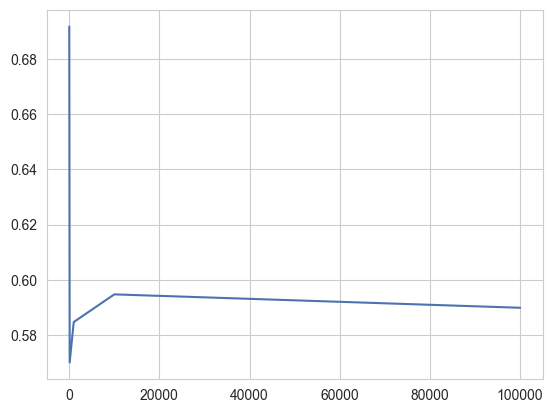

In [62]:
# 62 78, 1e5, 1e-8, 10000
np.random.seed(42)
# model = SVM(1e5, 1e-8, 10000)
# model = SVM(1e3, 1e-11, 15000)
lambdas = [1e1, 1e2, 1e3, 1e4, 1e5]
f1_score_svm = []
for l in lambdas:
    model = SVM(l, 1e-8, 10000)
    model.train(x_train, y_train)
    y_pred = model.predict(x_test)
    report = classification_report(y_test, y_pred, target_names=["Negative", "Positive"], output_dict=True)
    f1_score = report['weighted avg']['f1-score']
    f1_score_svm.append(f1_score)

plt.plot(lambdas, f1_score_svm)



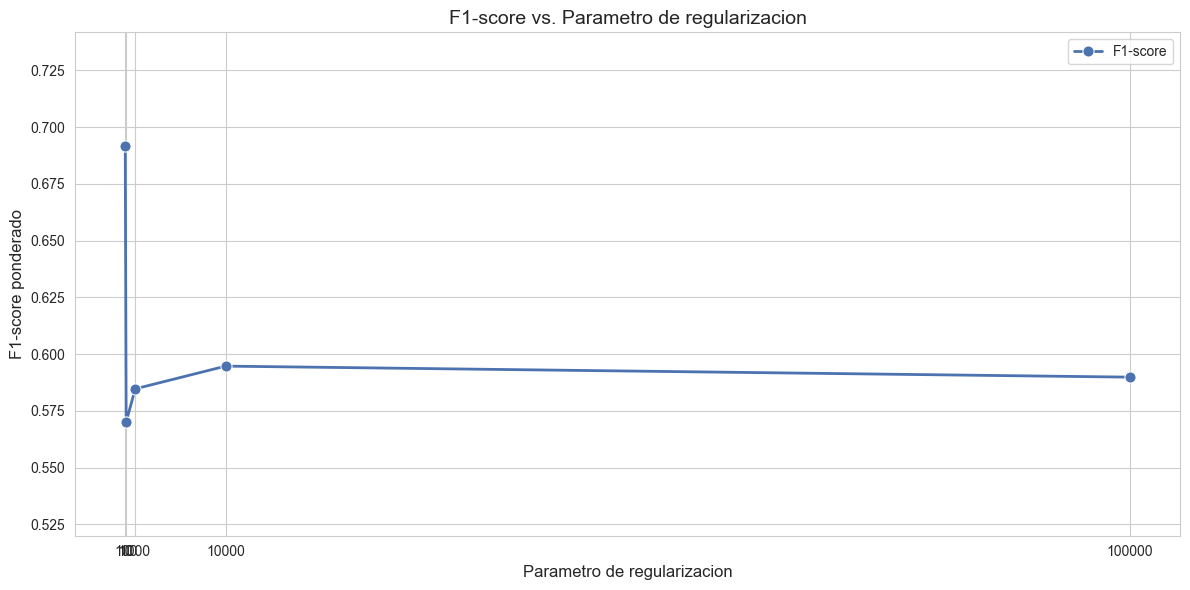

In [66]:
df = pd.DataFrame({'Parametro de regularizacion': lambdas, 'F1-score': f1_score_svm})

sns.set_style("whitegrid")
sns.set_palette("deep")

plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='Parametro de regularizacion', y='F1-score', marker='o', linewidth=2, markersize=8)

plt.xlabel('Parametro de regularizacion', fontsize=12)
plt.ylabel('F1-score ponderado', fontsize=12)
plt.title('F1-score vs. Parametro de regularizacion', fontsize=14)

plt.legend(['F1-score'], loc='best', fontsize=10)
plt.xticks(lambdas)
plt.ylim(min(f1_score_svm) - 0.05, max(f1_score_svm) + 0.05)

plt.tight_layout()
plt.show()

Fold 1:
Train Accuracy: 0.6979742173112339
Test Accuracy: 0.6942148760330579
              precision    recall  f1-score   support

    Negative       0.65      0.90      0.75       127
    Positive       0.81      0.47      0.59       115

    accuracy                           0.69       242
   macro avg       0.73      0.68      0.67       242
weighted avg       0.72      0.69      0.68       242

Fold 2:
Train Accuracy: 0.7007366482504604
Test Accuracy: 0.6776859504132231
              precision    recall  f1-score   support

    Negative       0.71      0.63      0.67       125
    Positive       0.65      0.73      0.69       117

    accuracy                           0.68       242
   macro avg       0.68      0.68      0.68       242
weighted avg       0.68      0.68      0.68       242

Fold 3:
Train Accuracy: 0.7030386740331491
Test Accuracy: 0.5537190082644629
              precision    recall  f1-score   support

    Negative       0.51      0.85      0.64       110
    Po

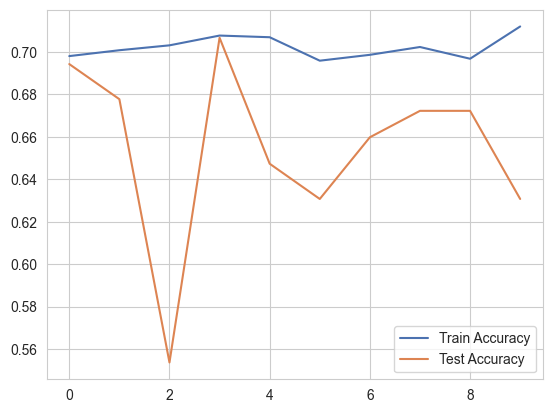

In [67]:
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report

np.random.seed(42)

n_folds = 10
kfold = KFold(n_splits=n_folds, shuffle=True, random_state=41)

accuracy_train = []
accuracy_test = []
precision_test = []
recall_test = []
f1_test = []


# Iterar por cada fold
i = 0
for train_index, test_index in kfold.split(X_data, Y_data):
    i += 1
    x_traink, x_testk = X_data[train_index], X_data[test_index]
    y_traink, y_testk = Y_data[train_index], Y_data[test_index]

    model = SVM(1e1, 1e-8, 10000)  
    
    model.train(x_traink, y_traink)
    
    y_train_pred = model.predict(x_traink)
    y_test_pred = model.predict(x_testk)
    
    train_accuracy = accuracy_score(y_traink, y_train_pred)
    test_accuracy = accuracy_score(y_testk, y_test_pred)
    
    accuracy_train.append(train_accuracy)
    accuracy_test.append(test_accuracy)
    
    print(f"Fold {i}:")
    print(f"Train Accuracy: {train_accuracy}")
    print(f"Test Accuracy: {test_accuracy}")
    
    print(classification_report(y_testk, y_test_pred, target_names=["Negative", "Positive"]))

plt.plot(accuracy_train, label="Train Accuracy")
plt.plot(accuracy_test, label="Test Accuracy")
plt.legend()
plt.show()


# KNN

# Logistica


In [25]:
r"""
LogisticRegression
===

This module contains an implementation of a logistic regression model class for our Machine Learning project.

This module exports:
  - LR class

Usage
-----
To create an instance of the LR class, do::

  >>> model = LR(alpha, lam)

Constructor parameters are (in order):
  - `alpha` the alpha constant - controls model reaction to slope change
  - `lam` lambda constant, used for regularization

To train a created model, do::

  >>> model.fit(x_train, y_train, epochs)

To predict using the model, do::

  >>> model.predict(x_test)

"""

class LR:

    def __init__(self, alpha, lam):
        self.alpha = alpha
        self.lam = lam
        self.w = None
    
    def normalize(self, data):
        min = np.min(data, axis=0)
        max = np.max(data, axis=0)
        return (data - min) / (max - min)
    
    def h(self, x):
        return np.dot(x, self.w.T)
    
    def s(self, x):
        return 1 / (1 + np.exp(-self.h(x)))
    
    def loss(self, y, y_aprox):
        n = len(y)
        ep = 1e-15
        y_aprox = np.clip(y_aprox, ep, 1 - ep)
        loss = -1 / n * np.sum(y * np.log(y_aprox) + (1 - y) * np.log(1 - y_aprox)) + self.lam * np.sum(self.w ** 2)
        return loss
    
    def derivatives(self, x, y):
        s = self.s(x)
        return (np.dot((s - y).T, x) / len(y)) + 2 * self.lam * self.w
    
    def update(self, d_w):
        self.w -= (self.alpha * d_w)
    
    def fit(self, x_train, y_train, epochs):
        x_train = self.normalize(x_train)
        n = x_train.shape[1]
        self.w = np.array([np.random.rand() for i in range(n)])
        for _ in range(epochs):
            y_aprox = self.s(x_train)
            d_w = self.derivatives(x_train, y_train)
            self.update(d_w)
    
    def predict(self, x_test):
        x_test = self.normalize(x_test)
        prob = self.s(x_test)
        pred = (prob >= 0.5).astype(int)  # Predice 0 o 1
        return np.where(pred == 0, -1, 1) 

              precision    recall  f1-score   support

    Negative       0.67      0.72      0.69       373
    Positive       0.67      0.62      0.65       352

    accuracy                           0.67       725
   macro avg       0.67      0.67      0.67       725
weighted avg       0.67      0.67      0.67       725



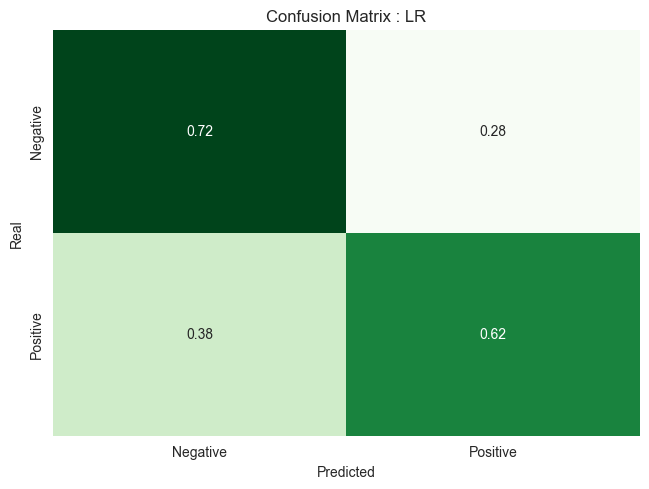

In [54]:
#62 63
np.random.seed(42)

y_train_lr = np.where(y_train == -1, 0, 1)

# Train the model LR
model = LR(0.01, 0.01)
model.fit(x_train, y_train_lr, 40000)
y_pred = model.predict(x_test)
print(classification_report(y_test, y_pred, target_names=["Negative", "Positive"]))
matriz_confusion(y_pred, y_test, " : LR")

Fold 1:
Train Accuracy: 0.4972375690607735
Test Accuracy: 0.5247933884297521
              precision    recall  f1-score   support

    Negative       0.52      1.00      0.69       127
    Positive       0.00      0.00      0.00       115

    accuracy                           0.52       242
   macro avg       0.26      0.50      0.34       242
weighted avg       0.28      0.52      0.36       242



C:\Code\UTEC\ML\Project2_Git\ML_Proyecto2_Grupo8\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Code\UTEC\ML\Project2_Git\ML_Proyecto2_Grupo8\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Code\UTEC\ML\Project2_Git\ML_Proyecto2_Grupo8\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

Fold 2:
Train Accuracy: 0.498158379373849
Test Accuracy: 0.5165289256198347
              precision    recall  f1-score   support

    Negative       0.52      1.00      0.68       125
    Positive       0.00      0.00      0.00       117

    accuracy                           0.52       242
   macro avg       0.26      0.50      0.34       242
weighted avg       0.27      0.52      0.35       242



C:\Code\UTEC\ML\Project2_Git\ML_Proyecto2_Grupo8\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Code\UTEC\ML\Project2_Git\ML_Proyecto2_Grupo8\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Code\UTEC\ML\Project2_Git\ML_Proyecto2_Grupo8\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

Fold 3:
Train Accuracy: 0.5050644567219152
Test Accuracy: 0.45454545454545453
              precision    recall  f1-score   support

    Negative       0.45      1.00      0.62       110
    Positive       0.00      0.00      0.00       132

    accuracy                           0.45       242
   macro avg       0.23      0.50      0.31       242
weighted avg       0.21      0.45      0.28       242



C:\Code\UTEC\ML\Project2_Git\ML_Proyecto2_Grupo8\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Code\UTEC\ML\Project2_Git\ML_Proyecto2_Grupo8\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Code\UTEC\ML\Project2_Git\ML_Proyecto2_Grupo8\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

Fold 4:
Train Accuracy: 0.5009208103130756
Test Accuracy: 0.49173553719008267
              precision    recall  f1-score   support

    Negative       0.49      1.00      0.66       119
    Positive       0.00      0.00      0.00       123

    accuracy                           0.49       242
   macro avg       0.25      0.50      0.33       242
weighted avg       0.24      0.49      0.32       242



C:\Code\UTEC\ML\Project2_Git\ML_Proyecto2_Grupo8\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Code\UTEC\ML\Project2_Git\ML_Proyecto2_Grupo8\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Code\UTEC\ML\Project2_Git\ML_Proyecto2_Grupo8\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

Fold 5:
Train Accuracy: 0.5011504832029452
Test Accuracy: 0.4896265560165975
              precision    recall  f1-score   support

    Negative       0.49      1.00      0.66       118
    Positive       0.00      0.00      0.00       123

    accuracy                           0.49       241
   macro avg       0.24      0.50      0.33       241
weighted avg       0.24      0.49      0.32       241



C:\Code\UTEC\ML\Project2_Git\ML_Proyecto2_Grupo8\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Code\UTEC\ML\Project2_Git\ML_Proyecto2_Grupo8\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Code\UTEC\ML\Project2_Git\ML_Proyecto2_Grupo8\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

Fold 6:
Train Accuracy: 0.49102623101702714
Test Accuracy: 0.5809128630705395
              precision    recall  f1-score   support

    Negative       0.58      1.00      0.73       140
    Positive       0.00      0.00      0.00       101

    accuracy                           0.58       241
   macro avg       0.29      0.50      0.37       241
weighted avg       0.34      0.58      0.43       241



C:\Code\UTEC\ML\Project2_Git\ML_Proyecto2_Grupo8\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Code\UTEC\ML\Project2_Git\ML_Proyecto2_Grupo8\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Code\UTEC\ML\Project2_Git\ML_Proyecto2_Grupo8\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

Fold 7:
Train Accuracy: 0.49976990335941096
Test Accuracy: 0.5020746887966805
              precision    recall  f1-score   support

    Negative       0.50      1.00      0.67       121
    Positive       0.00      0.00      0.00       120

    accuracy                           0.50       241
   macro avg       0.25      0.50      0.33       241
weighted avg       0.25      0.50      0.34       241



C:\Code\UTEC\ML\Project2_Git\ML_Proyecto2_Grupo8\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Code\UTEC\ML\Project2_Git\ML_Proyecto2_Grupo8\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Code\UTEC\ML\Project2_Git\ML_Proyecto2_Grupo8\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

Fold 8:
Train Accuracy: 0.5011504832029452
Test Accuracy: 0.4896265560165975
              precision    recall  f1-score   support

    Negative       0.49      1.00      0.66       118
    Positive       0.00      0.00      0.00       123

    accuracy                           0.49       241
   macro avg       0.24      0.50      0.33       241
weighted avg       0.24      0.49      0.32       241



C:\Code\UTEC\ML\Project2_Git\ML_Proyecto2_Grupo8\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Code\UTEC\ML\Project2_Git\ML_Proyecto2_Grupo8\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Code\UTEC\ML\Project2_Git\ML_Proyecto2_Grupo8\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

Fold 9:
Train Accuracy: 0.5066728025770824
Test Accuracy: 0.43983402489626555
              precision    recall  f1-score   support

    Negative       0.44      1.00      0.61       106
    Positive       0.00      0.00      0.00       135

    accuracy                           0.44       241
   macro avg       0.22      0.50      0.31       241
weighted avg       0.19      0.44      0.27       241



C:\Code\UTEC\ML\Project2_Git\ML_Proyecto2_Grupo8\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Code\UTEC\ML\Project2_Git\ML_Proyecto2_Grupo8\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Code\UTEC\ML\Project2_Git\ML_Proyecto2_Grupo8\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

Fold 10:
Train Accuracy: 0.49884951679705475
Test Accuracy: 0.5103734439834025
              precision    recall  f1-score   support

    Negative       0.51      1.00      0.68       123
    Positive       0.00      0.00      0.00       118

    accuracy                           0.51       241
   macro avg       0.26      0.50      0.34       241
weighted avg       0.26      0.51      0.34       241



C:\Code\UTEC\ML\Project2_Git\ML_Proyecto2_Grupo8\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Code\UTEC\ML\Project2_Git\ML_Proyecto2_Grupo8\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Code\UTEC\ML\Project2_Git\ML_Proyecto2_Grupo8\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

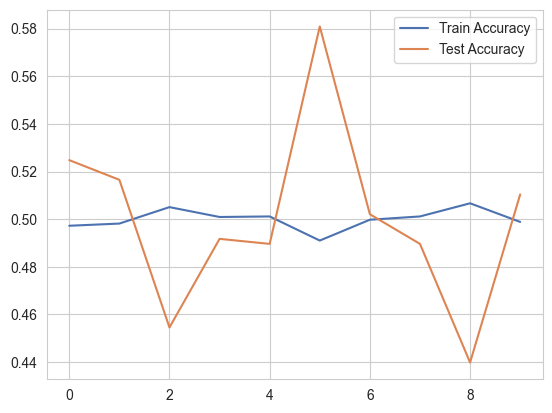

In [50]:
np.random.seed(42)

n_folds = 10
kfold = KFold(n_splits=n_folds, shuffle=True, random_state=41)

accuracy_train = []
accuracy_test = []
precision_test = []
recall_test = []
f1_test = []


Y_data_lr = np.where(Y_data == -1, 0, 1)

# Iterar por cada fold
i = 0
for train_index, test_index in kfold.split(X_data, Y_data_lr):
    i += 1
    x_traink, x_testk = X_data[train_index], X_data[test_index]
    y_traink, y_testk = Y_data[train_index], Y_data[test_index]

    model = LR(0.1, 0.01)
    model.fit(x_traink, y_traink, 20000)
    
    y_train_pred = model.predict(x_traink)
    y_test_pred = model.predict(x_testk)
    
    train_accuracy = accuracy_score(y_traink, y_train_pred)
    test_accuracy = accuracy_score(y_testk, y_test_pred)
    
    accuracy_train.append(train_accuracy)
    accuracy_test.append(test_accuracy)
    
    print(f"Fold {i}:")
    print(f"Train Accuracy: {train_accuracy}")
    print(f"Test Accuracy: {test_accuracy}")
    
    print(classification_report(y_testk, y_test_pred, target_names=["Negative", "Positive"]))

plt.plot(accuracy_train, label="Train Accuracy")
plt.plot(accuracy_test, label="Test Accuracy")
plt.legend()
plt.show()